In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [53]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [54]:
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
# train_set = ImageData(train_path,transform,label_transform)
train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
# val_set = ImageData(val_path,transform,label_transform)
val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [55]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img.shape)
#temp = temp_img[0][0] + temp_img[0][1] + temp_img[0][2]
#plt.imshow(temp)

366


In [56]:
class FCN32(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN32, self).__init__()
        self.conv1 = self.make_block(in_channel=3, out_channel=64,repeat=2)
        self.conv2 = self.make_block(in_channel=64,out_channel=128,repeat=2)
        self.conv3 = self.make_block(128,256,3)
        self.conv4 = self.make_block(256,512,3)
        self.conv5 = self.make_block(512,512,3)

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=7)
        self.fc2 = nn.Conv2d(4096,4096,1)
        self.fc3 = nn.Conv2d(4096,num_class,1)

        self.upsample32 = nn.ConvTranspose2d(in_channels=num_class,out_channels=num_class,
        kernel_size=224,stride=32)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # x = self.vgg16(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc3(x)
        x = self.upsample32(x)
        return x

    def make_block(self, in_channel, out_channel, repeat):
        layers = []
        for i in range(repeat):
            if (i==0):
                layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
            else:
                layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        block = nn.Sequential(*layers)

        return block

In [57]:
FCN =FCN32(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792           1,792
        BatchNorm2d-2      [4, 64, 224, 224]             128             128
               ReLU-3      [4, 64, 224, 224]               0               0
             Conv2d-4      [4, 64, 224, 224]          36,928          36,928
        BatchNorm2d-5      [4, 64, 224, 224]             128             128
               ReLU-6      [4, 64, 224, 224]               0               0
          MaxPool2d-7      [4, 64, 224, 224]               0               0
             Conv2d-8      [4, 64, 112, 112]          73,856          73,856
        BatchNorm2d-9     [4, 128, 112, 112]             256             256
              ReLU-10     [4, 128, 112, 112]               0               0
            Conv2d-11     [4, 128, 112, 112]         147,

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.001)

In [59]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)
            

In [60]:
# 학습
FCN.to(device)
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
for epoch in range(20):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)

        print(f'{epoch} epcoh , time = {time.time()-start_time}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list}
print('Finish Training')

366it [01:02,  5.85it/s]
363it [00:21, 16.50it/s]


0 epcoh , time = 84.59253215789795
train loss : 1.47020, val_loss : 1.44424
train IoU : 0.13145, val IoU : 0.12939


366it [01:02,  5.82it/s]
363it [00:21, 17.24it/s]


1 epcoh , time = 83.93689560890198
train loss : 1.37219, val_loss : 1.30253
train IoU : 0.12967, val IoU : 0.12949


366it [01:01,  5.93it/s]
363it [00:20, 17.51it/s]


2 epcoh , time = 82.44629144668579
train loss : 1.29863, val_loss : 1.35681
train IoU : 0.12856, val IoU : 0.12983


366it [01:02,  5.82it/s]
363it [00:21, 16.86it/s]


3 epcoh , time = 84.40709233283997
train loss : 1.28488, val_loss : 1.26051
train IoU : 0.12941, val IoU : 0.13085


272it [00:46,  5.86it/s]


KeyboardInterrupt: 

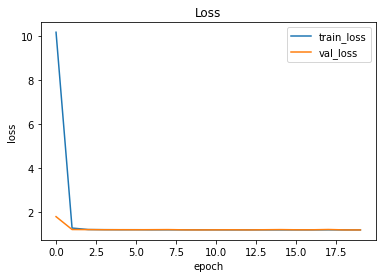

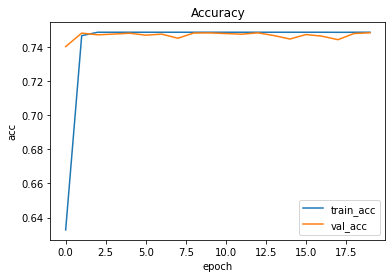

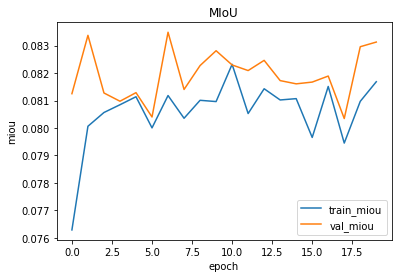

In [ ]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list}

def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

TypeError: 'int' object is not callable

torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])
tensor([[13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        ...,
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13],
        [13, 13, 13,  ..., 13, 13, 13]], device='cuda:0')


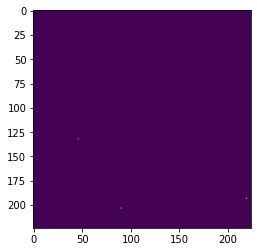

In [ ]:
a, b= train_set[0]
FCN.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        a, b = data
        FCN.to(device)
        print(a.shape)
        a = a.to(device)
        c = FCN(a)
        break

print(c.shape)
#mask = torch.argmax(c, dim=1)
print(c[0])
plt.imshow(c[0].cpu())
# t = a.view(8,224,224,3)
# # t = t.view(224,224,3)
# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(mask[0].cpu())
# plt.subplot(1,3,2)
# plt.imshow(b[0].cpu())
# plt.subplot(1,3,3)
# plt.imshow(t[0].cpu())
